In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
import calendar;
import time;
import shutil
import os

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

print(tf.__version__)

2.0.0


In [3]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    #hist = hist.loc[150:]

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [ReportTime]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,500])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$ReportTime^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,300000])
    plt.legend()
    plt.show()

In [4]:
def copyDirectory(src, dest):
    try:
        shutil.copytree(src, dest)
    # Directories are the same
    except shutil.Error as e:
        print('Directory not copied. Error: %s' % e)
    # Any error saying that the directory doesn't exist
    except OSError as e:
        print('Directory not copied. Error: %s' % e)

In [5]:
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

In [11]:
def fetch_data():
    # read training data
    # report_id - ID to identify report
    # report_params - number of parameters to execute report (when more params specified - report will be generated faster)
    # day_part - when report is executed (morning, midday or afternoon) - there is less load in the morning and in the afternoon reports are generated slower
    # exec_time - time spent to produce report
    
    # Suppose data is changed and we need to re-train model
    column_names = ['report_id','report_params','day_part','exec_time']
    dataframe = pd.read_csv('report_exec_times.csv')
    dataframe_test = pd.read_csv('report_exec_times_test.csv')
    
    print('Time, mean for test dataset:', dataframe_test["exec_time"].mean())
    
    # Normalize training feature - report_params
    eps=0.001
    dataframe['report_params'] = np.log(dataframe.pop('report_params')+eps)
    normed_df = dataframe
    
    # Normalize test feature - report_params
    eps=0.001
    dataframe_test['report_params'] = np.log(dataframe_test.pop('report_params')+eps)
    normed_df_test = dataframe_test
    
    # Data is automatically shuffled during split
    train, val = train_test_split(normed_df, test_size=0.2)
    print(len(train), 'train examples')
    print(len(val), 'validation examples')
    print(len(normed_df_test), 'test examples')
    
    return train, val, normed_df_test

In [5]:
def build_feature_layer():
    feature_columns = []

    report_id = feature_column.categorical_column_with_vocabulary_list('report_id', [1, 2, 3, 4, 5])
    report_id_one_hot = feature_column.indicator_column(report_id)
    feature_columns.append(report_id_one_hot)

    feature_columns.append(feature_column.numeric_column('report_params'))

    day_part = feature_column.categorical_column_with_vocabulary_list('day_part', [1, 2, 3])
    day_part_one_hot = feature_column.indicator_column(day_part)
    feature_columns.append(day_part_one_hot)
    
    feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
    
    return feature_layer

In [6]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('exec_time')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [7]:
# Build TensorFlow dataset
def build_dataset():
    train, val, normed_df_test = fetch_data()
    
    batch_size = 16
    train_ds = df_to_dataset(train, shuffle=False, batch_size=batch_size)
    val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
    test_ds = df_to_dataset(normed_df_test, shuffle=False, batch_size=batch_size)
    
    return train_ds, val_ds, test_ds

In [8]:
# Construct neural network with Keras API on top of TensorFlow. RMSprop optimizer and mean squared error loss to check training quality
def build_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [9]:
def train_model():
    best_history = None
    best_rmse = 1000
    
    train_ds, val_ds, test_ds = build_dataset()

    for i in range(10):
        print('Model training:', i+1)
        
        tf.keras.backend.clear_session()
        
        feature_layer = build_feature_layer()
        model = build_model(feature_layer)
        
        EPOCHS = 1000
        # The patience parameter is the amount of epochs to check for improvement
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
        
        history = model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=EPOCHS,
                      verbose=0,
                      callbacks=[early_stop])

        loss, mae, mse = model.evaluate(test_ds, verbose=0)

        rmse = math.sqrt(mse)
        print("Testing set RMSE Error:{:5.2f}".format(math.sqrt(mse)))
        if rmse < best_rmse:
            print("Saving model with RMSE Error:{:5.2f}".format(math.sqrt(mse)))
            model.save('./model_exec_time_temp/', save_format='tf')
            
            best_history = history
            best_rmse = rmse
            
    plot_history(best_history)
    print("Best RMSE Error:{:5.2f}".format(best_rmse))
    
    ts = calendar.timegm(time.gmtime())
    print('Creating new model:', ts)
    copyDirectory('./model_exec_time_temp/', './model_exec_time/' + str(ts))

W0428 08:23:16.595058 140217417520960 base_layer.py:1814] Layer sequential is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W0428 08:23:16.619943 140217417520960 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:4276: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_c

Time, mean: 483.668
4800 train examples
1200 validation examples
500 test examples
Model training: 1


W0428 08:25:22.834228 140217417520960 base_layer.py:1814] Layer dense_features is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Testing set RMSE Error:11.04
Saving model with RMSE Error:11.04


W0428 08:25:24.425730 140217417520960 deprecation.py:506] From /opt/conda/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0428 08:25:25.061463 140217417520960 base_layer.py:1814] Layer sequential is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='floa

Model training: 2


W0428 08:25:54.529050 140217417520960 base_layer.py:1814] Layer sequential is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Testing set RMSE Error:20.74
Model training: 3


W0428 08:26:27.251147 140217417520960 base_layer.py:1814] Layer sequential is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Testing set RMSE Error:21.05
Model training: 4
Testing set RMSE Error:10.44
Saving model with RMSE Error:10.44


W0428 08:28:55.100664 140217417520960 base_layer.py:1814] Layer dense_features is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W0428 08:28:57.039623 140217417520960 base_layer.py:1814] Layer sequential is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype de

Model training: 5


W0428 08:29:31.811933 140217417520960 base_layer.py:1814] Layer sequential is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Testing set RMSE Error:20.57
Model training: 6


W0428 08:34:29.378622 140217417520960 base_layer.py:1814] Layer dense_features is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Testing set RMSE Error: 9.98
Saving model with RMSE Error: 9.98


W0428 08:34:31.319272 140217417520960 base_layer.py:1814] Layer sequential is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Model training: 7


W0428 08:36:34.256778 140217417520960 base_layer.py:1814] Layer sequential is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Testing set RMSE Error:11.88
Model training: 8


W0428 08:39:46.795549 140217417520960 base_layer.py:1814] Layer sequential is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Testing set RMSE Error:12.82
Model training: 9


W0428 08:40:27.007449 140217417520960 base_layer.py:1814] Layer sequential is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Testing set RMSE Error:20.78
Model training: 10
Testing set RMSE Error:11.62


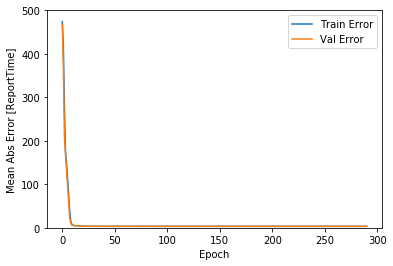

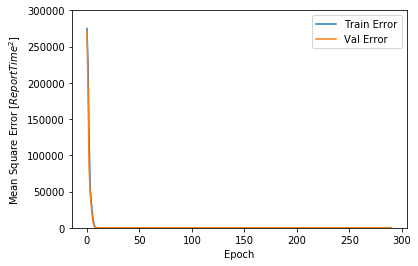

Best RMSE Error: 9.98
Creating new model: 1588063313


In [10]:
# train_model()

In [14]:
def prepare_input_data(input_data):
    # Construct test data row with "unseen" feature values - report_id = 1, report_params = 15, day_part = 3 
    headers = ['report_id', 'report_params', 'day_part']
    dataframe_input = pd.DataFrame(input_data,
                                    columns=headers, 
                                    dtype=int,
                                    index=['input'])

    # Normalize report_params
    eps=0.001
    dataframe_input['report_params'] = np.log(dataframe_input.pop('report_params')+eps)
    dataframe_input_normed = dataframe_input
    
    input_ds = tf.data.Dataset.from_tensor_slices(dict(dataframe_input_normed))
    input_ds = input_ds.batch(1)

    for feature_batch in input_ds.take(1):
      for key, value in feature_batch.items():
        print("  {!r:20s}: {}".format(key, value))
        
    return input_ds

In [39]:
# Prediction result for report execution time. This is correct, model learns the rule correct - more report params, means execution time will be less
def run_predict(input_data):
    input_ds = prepare_input_data(input_data)
    
    folders = get_immediate_subdirectories('./model_exec_time/')
    
    saved_model = tf.keras.models.load_model('./model_exec_time/' + max(folders))
    res = saved_model.predict(input_ds)
    
    return res

In [40]:
# run_predict([[1, 15, 3]])

  'report_id'         : [1]
  'day_part'          : [3]
  'report_params'     : [2.70811687]
1588063313


W0428 09:31:48.821199 140217417520960 base_layer.py:1814] Layer sequential is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



[[432.03558]]


In [25]:
# run_predict([[1, 15, 1]])

  'report_id'         : [1]
  'day_part'          : [1]
  'report_params'     : [2.70811687]


W0428 09:04:56.737883 140217417520960 base_layer.py:1814] Layer sequential is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



[[311.23544]]
